In [40]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [41]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [43]:
np.random.seed(0)

In [44]:
# Implement load the data here
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
    
# TODO: Load test data
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

In [45]:
# Split out features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [46]:
#Shape of the data
print(X_train.shape) # 34799 images that are 32x32 pixels and have 3 channels (RGB)
print(X_test.shape) # 12630 images that are 32x32 pixels and have 3 channels (RGB)
print(X_val.shape) # 4410 images that are 32x32 pixels and have 3 channels (RGB)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [47]:
# Make sure the number of images is equal to the labels. 
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."

# Make sure the dimension of all images are 32 x 32 x 3
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

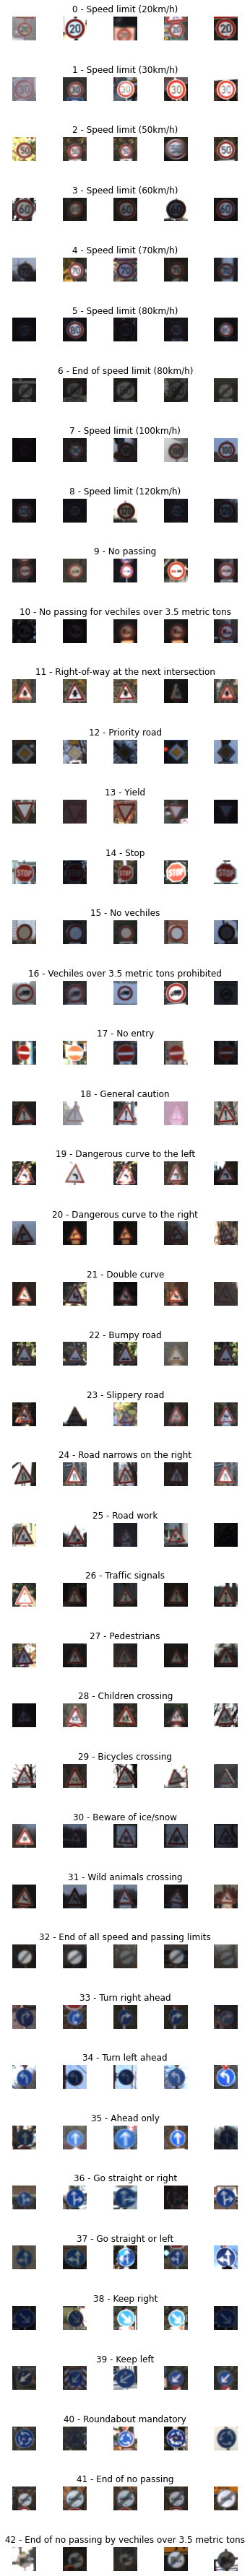

In [48]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
  
num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


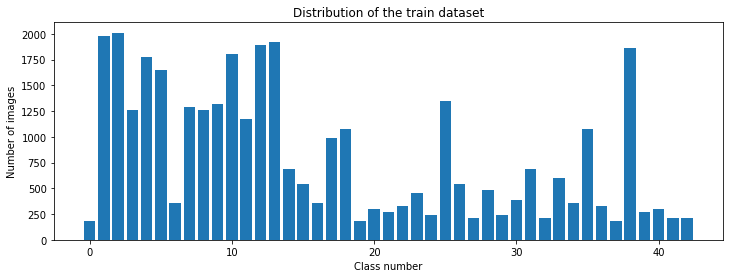

In [49]:
# See the number of data for each class
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


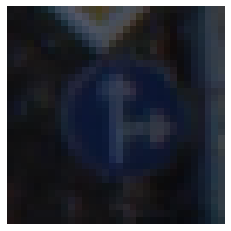

In [50]:
import cv2

# Show the shape of 1000th data
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


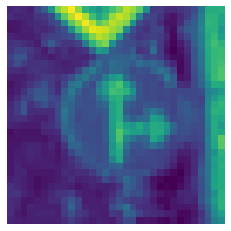

In [51]:
# Grayscaling image to see the sign more clearly
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


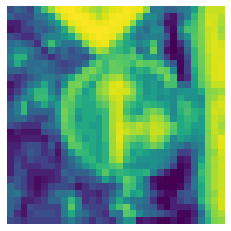

In [52]:
# Normalize the lightening of the image
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [53]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

In [54]:
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

(34799, 32, 32)


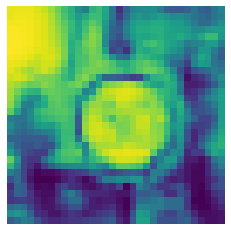

In [55]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [56]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [57]:
# Use Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)

datagen.fit(X_train)

(15, 32, 32, 1)


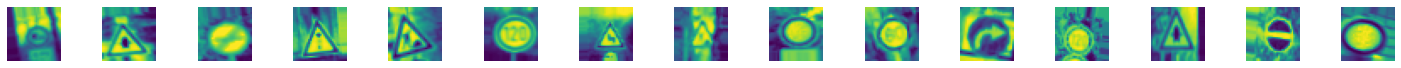

In [58]:
# for X_batch, y_batch in

batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")

print(X_batch.shape)

In [59]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [60]:
# create model

def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [61]:
model = modified_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 60)        1560      
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 60)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                  

In [86]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                            steps_per_epoch=1050,
                            epochs=10,
                            validation_data=(X_val, y_val), shuffle = 1)

Epoch 1/10
   3/1050 [..............................] - ETA: 26s - loss: 0.1303 - accuracy: 0.9792

<ipython-input-86-6ed2d5022b8e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),


1050/1050 [==============================] - 17s 16ms/step - loss: 0.0846 - accuracy: 0.9744 - val_loss: 0.0281 - val_accuracy: 0.9916
Epoch 2/10
1050/1050 [==============================] - 16s 16ms/step - loss: 0.0824 - accuracy: 0.9745 - val_loss: 0.0700 - val_accuracy: 0.9828
Epoch 3/10
1050/1050 [==============================] - 17s 16ms/step - loss: 0.0785 - accuracy: 0.9758 - val_loss: 0.0461 - val_accuracy: 0.9880
Epoch 4/10
1050/1050 [==============================] - 17s 16ms/step - loss: 0.0796 - accuracy: 0.9765 - val_loss: 0.0892 - val_accuracy: 0.9900
Epoch 5/10
1050/1050 [==============================] - 16s 16ms/step - loss: 0.0749 - accuracy: 0.9779 - val_loss: 0.0231 - val_accuracy: 0.9927
Epoch 6/10
1050/1050 [==============================] - 16s 15ms/step - loss: 0.0740 - accuracy: 0.9782 - val_loss: 0.0374 - val_accuracy: 0.9880
Epoch 7/10
1050/1050 [==============================] - 16s 15ms/step - loss: 0.0798 - accuracy: 0.9773 - val_loss: 0.0431 - val_accura

Text(0.5, 0, 'epoch')

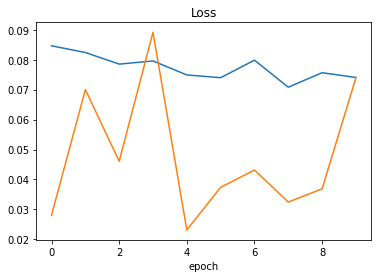

In [87]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

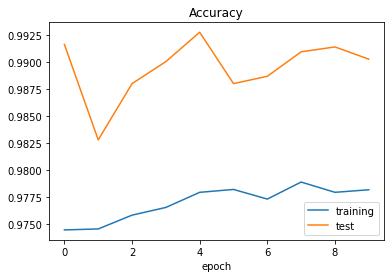

In [88]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [89]:
# Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.12746678292751312
Test accuracy: 0.9707046747207642


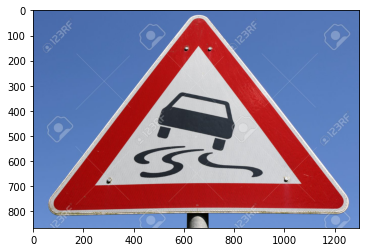

In [94]:
#predict internet number
import requests
from PIL import Image
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


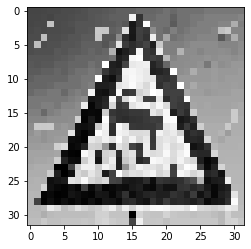

In [95]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [96]:
img = img.reshape(1, 32, 32, 1)

In [97]:
print("predicted sign: "+ str(np.argmax(model.predict(img), axis=-1)))

1/1 [==============================] - 0s 18ms/step
predicted sign: [23]
